In [6]:
import jax
import jax.numpy as jnp
import jax.scipy as jsp
from jax.nn import softmax
from fastprogress import progress_bar

import blackjax
import blackjax.sgmcmc.gradients as gradients

def halfnorm_logpdf(x, scale=1.0):
    log_pdf = 0.5 * jnp.log(2) - 0.5 * jnp.log(jnp.pi) - jnp.log(scale) - (x**2 / (2 * scale**2))
    return jnp.where(x >= 0, log_pdf, -jnp.inf)

def logprior_fn(state):
    mu_prior = 0.0
    sigma_prior = halfnorm_logpdf(state["sigma"])
    # w_prior = jax.scipy.stats.dirichlet.logpdf(state["w"], jnp.array([1.0, 1.0]))
    return mu_prior + sigma_prior #+ w_prior

def loglikelihood_fn(state, x):
    mixture_1 = jax.scipy.stats.norm.logpdf(x, loc=state["position"], scale=state["sigma"])
    mixture_2 = jax.scipy.stats.norm.logpdf(x, loc=-state["position"] + 20.0, scale=state["sigma"])
    return jsp.special.logsumexp(jnp.array([mixture_1, mixture_2])) + jnp.log(0.5)

def sample_fn(rng_key, num_samples, mu=-5.0, sigma=5, gamma=20.0):
    key1, key2, key3 = jax.random.split(rng_key, 3)
    prob_mixture = jax.random.bernoulli(key1, p=0.5, shape=(num_samples, 1))
    mixture_1 = jax.random.normal(key2, shape=(num_samples, 1)) * sigma + mu
    mixture_2 = jax.random.normal(key3, shape=(num_samples, 1)) * sigma + gamma - mu
    return prob_mixture * mixture_1 + (1 - prob_mixture) * mixture_2

data_size = 100
rng_key = jax.random.PRNGKey(888)
rng_key, sample_key = jax.random.split(rng_key)
X_data = sample_fn(sample_key, data_size)

total_iter = 10_000
thinning_factor = 10

batch_size = 100
lr = 1e-5
zeta = 2
sz = 100
temperature = 10

num_partitions = 100000
energy_gap = 0.25
domain_radius = 50 

grad_fn = gradients.grad_estimator(logprior_fn, loglikelihood_fn, data_size)
logdensity_fn = gradients.logdensity_estimator(logprior_fn, loglikelihood_fn, data_size)
# sgld = blackjax.sgld(grad_fn)
csgld = blackjax.csgld(
    logdensity_fn,
    grad_fn,
    zeta=zeta,  # can be specified at each step in lower-level interface
    num_partitions=num_partitions,  # cannot be specified at each step
    energy_gap=energy_gap,  # cannot be specified at each step
    min_energy=0,
)
init_state = {"position": 10.0, "sigma": 1.0}
state = csgld.init(init_state)

sgld_position_sample_list = []
sgld_sigma_sample_list = []
sgld_w_sample_list = []

sample_idx = 0

pb = progress_bar(range(total_iter))
for iter_ in pb:
    rng_key, subkey = jax.random.split(rng_key)
    stepsize_SA = min(1e-2, (iter_ + 100) ** (-0.8)) * sz
    data_batch = jax.random.permutation(subkey, X_data, independent=True)[:batch_size, :]
    
    state = jax.jit(csgld.step)(subkey, state, data_batch, lr, stepsize_SA)
    
    if iter_ % thinning_factor == 0:
        sgld_position_sample_list.append(state.position["position"])
        sgld_sigma_sample_list.append(state.position["sigma"])
        sample_idx += 1
        pb.comment = f"| position: {state.position['position']:.2f} | sigma: {state.position['sigma']:.2f} |"

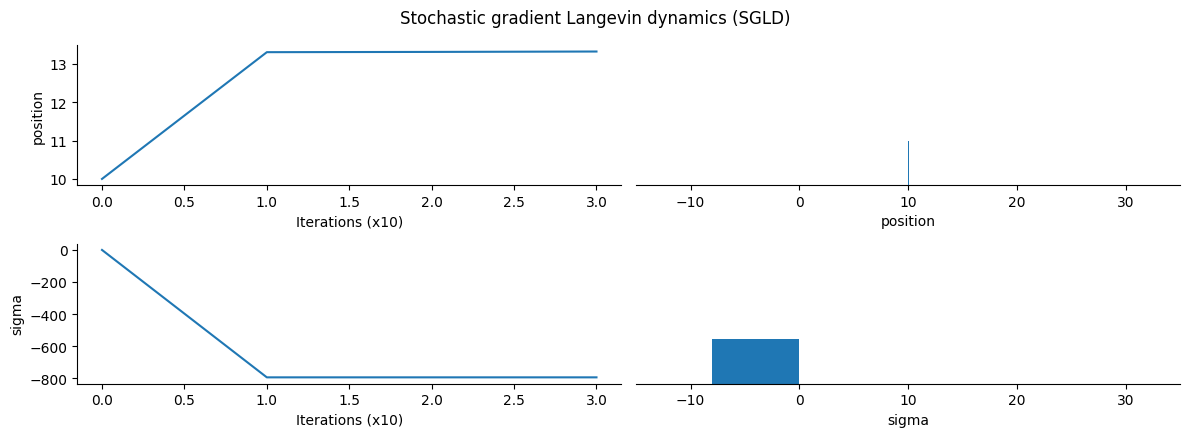

In [7]:
import matplotlib.gridspec as gridspec
import matplotlib.pylab as plt

fig = plt.figure(figsize=(12, 6))

# Define a grid of 3x2: 3 parameters and 2 types of plots
G = gridspec.GridSpec(3, 2)

samples = [sgld_position_sample_list, sgld_sigma_sample_list]
names = ["position", "sigma"]

for i, (name, sample_list) in enumerate(zip(names, samples)):
    # Time series plot
    ax = plt.subplot(G[i, 0])
    ax.plot(sample_list, label="SGLD")
    ax.set_xlabel(f"Iterations (x{thinning_factor})")
    ax.set_ylabel(name)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Histogram
    ax = plt.subplot(G[i, 1])
    ax.hist(sample_list, 100)
    ax.set_xlabel(name)
    ax.set_xlim(left=-15, right=35)
    ax.set_yticks([])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)

plt.suptitle("Stochastic gradient Langevin dynamics (SGLD)")
plt.tight_layout()
plt.show()


In [4]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer.util import initialize_model
from numpyro.infer import HMCECS, MCMC, NUTS
import blackjax
import jax
from jax import random, vmap
import jax.numpy as jnp
from fastprogress import progress_bar
import pickle

import os
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=16"

def t_mixture_model(states, data_len, data=None):
    n_states = len(states)

    weights = numpyro.sample("weights", dist.Dirichlet(concentration=jnp.ones(n_states)))
    n = numpyro.sample("n", dist.Beta(15, 1.5))
    s = numpyro.sample("s", dist.Beta(3, 15))
    phi = numpyro.sample("phi", dist.Gamma(2.5, 2))

    mu = numpyro.deterministic("mu", jnp.log((2 * n + (1 - n) * ((1 - s) * states[:, 0] + s * states[:, 1])) / (2 * n + (1 - n) * phi)))

    with numpyro.plate("states", n_states):
        scale = numpyro.sample("scale", dist.Gamma(2, 2))

    with numpyro.plate("data", data_len):
        numpyro.sample("obs", dist.MixtureSameFamily(dist.Categorical(weights), dist.Normal(mu, scale), validate_args=False), obs=data)

states = jnp.array([[c, c-1] for c in range(1, 6)] + 
                   [[c, c] for c in range(6)] + 
                   [[c, c+1] for c in range(6)] +
                    [[c, 2] for c in range(6)])

regions = pickle.load(open('test/luad34.regions.entropies.pkl', 'rb'))
data = jnp.array(regions[regions.chrom != 19].loc[:, 'log2_corrected'].values)
data = data.reshape(-1, 1)


In [5]:

rng_key = jax.random.PRNGKey(0)
init_params, potential_fn_gen, *_ = initialize_model(
    rng_key,
    t_mixture_model,
    model_args=(states, data.shape[0], data),
    dynamic_args=True,
)

logdensity_fn = lambda position: -potential_fn_gen(states, data.shape[0], data)(position)
initial_position = init_params.z

grad_fn = lambda x, *_: jax.grad(logdensity_fn)(x)
sgld = blackjax.sgld(grad_fn)



/tmp/ipykernel_27026/2565568296.py:2: UserWarning: Missing a plate statement for batch dimension -2 at site 'obs'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  init_params, potential_fn_gen, *_ = initialize_model(


XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory allocating 231747885604 bytes.

In [ ]:
num_training_steps = 50000
schedule_fn = lambda k: 0.01 * k ** (-0.55)
schedule = [schedule_fn(i) for i in range(1, num_training_steps+1)]

position = {
    'n': jnp.array([0.9], dtype=jnp.float32), 
    'phi': jnp.array([0.9], dtype=jnp.float32), 
    's': jnp.array([0.9], dtype=jnp.float32), 
    'weights': jnp.array([1/22] * 22, dtype=jnp.float32),
    'scale': jnp.array([0.1] * 23, dtype=jnp.float32)
    }
# position = initial_position
samples = []

lr = 1e-5
total_iter = 1_000
batch_size = 100
thinning_factor = 10
pb = progress_bar(range(total_iter))
for iter_ in pb:
    rng_key, batch_key, sample_key = jax.random.split(rng_key, 3)
    data_batch = jax.random.shuffle(batch_key, data)[:batch_size]
    position = jax.jit(sgld.step)(sample_key, position, data_batch, lr)
    if iter_ % thinning_factor == 0:
        samples.append(position)
        print(position['n'], end='\r')
        # pb.comment = f"| position: {position['n']: .2f}"

KeyboardInterrupt: 

In [ ]:
for s in samples:
    print(s['n'], end='\r')